## Dynamic Risk Budgeting

In [31]:
import numpy as np
import pandas as pd
import AKCRiskKit as ark
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
n_scenarios = 5000
rates, zc_prices = ark.cir(10,n_scenarios=n_scenarios,b=0.03,r_0=0.03,sigma=0.02)
price_eq = ark.gbm(10,n_scenarios=n_scenarios,mu=0.07,sigma=0.15)

In [13]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_75floor = ark.bt_mix(rets_eq,rets_zc,allocator=ark.floor_allocator, floor=0.75,zc_prices=zc_prices[1:])
pd.concat([
    ark.terminal_stats(rets_zc,name="zc",floor=0.75),
    ark.terminal_stats(rets_eq,name="Equity",floor=0.75),
    ark.terminal_stats(rets_75floor,name="Floor 75",floor=0.75)

    ],axis=1).round(2)

,zc,Equity,Floor 75
mean,1.34,1.98,1.96
std,0.00,1.01,1.01
p_breach,NaN,0.04,NaN
e_short,NaN,0.12,NaN
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [16]:
rets_75floorm1 = ark.bt_mix(rets_eq,rets_zc,allocator=ark.floor_allocator, floor=0.75,zc_prices=zc_prices[1:],m=1)
rets_75floorm5 = ark.bt_mix(rets_eq,rets_zc,allocator=ark.floor_allocator, floor=0.75,zc_prices=zc_prices[1:],m=5)


In [17]:
pd.concat([
    ark.terminal_stats(rets_zc,name="zc",floor=0.75),
    ark.terminal_stats(rets_eq,name="Equity",floor=0.75),
    ark.terminal_stats(rets_75floor,name="Floor 75",floor=0.75),
    ark.terminal_stats(rets_75floorm1,name="Floor 75",floor=0.75),
    ark.terminal_stats(rets_75floorm5,name="Floor 75",floor=0.75)

    ],axis=1).round(2)

,zc,Equity,Floor 75,Floor 75,Floor 75
mean,1.34,1.98,1.96,1.63,1.97
std,0.00,1.01,1.01,0.45,1.02
p_breach,NaN,0.04,NaN,NaN,NaN
e_short,NaN,0.12,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


## Risk Budgeting with Drawdown Constraints

In [19]:
cashrate = 0.02
monthly_cash_return = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cash_return, index = rets_eq.index,columns = rets_eq.columns)
rets_maxdd25 = ark.bt_mix(rets_eq,rets_cash,allocator=ark.drawdown_allocator,maxdd=0.25)

In [20]:
tv_maxdd25 = ark.terminal_values(rets_maxdd25)
pd.concat([
    ark.terminal_stats(rets_zc,name="zc",floor=0.75),
    ark.terminal_stats(rets_eq,name="Equity",floor=0.75),
    ark.terminal_stats(rets_75floor,name="Floor 75",floor=0.75),
    ark.terminal_stats(rets_75floorm1,name="Floor 75",floor=0.75),
    ark.terminal_stats(rets_75floorm5,name="Floor 75",floor=0.75),
    ark.terminal_stats(rets_maxdd25,name="Max DD 25",floor=0.75)


    ],axis=1).round(2)

,zc,Equity,Floor 75,Floor 75,Floor 75,Max DD 25
mean,1.34,1.98,1.96,1.63,1.97,1.64
std,0.00,1.01,1.01,0.45,1.02,0.55
p_breach,NaN,0.04,NaN,NaN,NaN,NaN
e_short,NaN,0.12,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
ark.summary_stats(rets_maxdd25)["Max Drawdown"]

0      -0.184944
1      -0.158257
2      -0.167839
3      -0.175104
4      -0.136135
          ...   
4995   -0.140872
4996   -0.170276
4997   -0.149755
4998   -0.159832
4999   -0.133687
Name: Max Drawdown, Length: 5000, dtype: float64

In [22]:
ark.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.2336217640168237

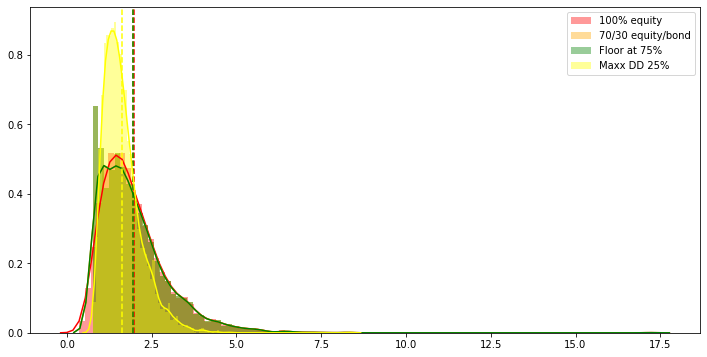

In [34]:
# Plot
tv_eq = ark.terminal_values(rets_eq)
tv_7030b = ark.terminal_values(rets_7030b)
tv_75floor = ark.terminal_values(rets_75floor)
tv_maxdd25 = ark.terminal_values(rets_maxdd25)
tv_75floorm1 = ark.terminal_values(rets_75floorm1)

plt.figure(figsize=(12,6))
sns.distplot(tv_eq,color="red",label="100% equity", bins=100)
plt.axvline(tv_eq.mean(),ls="--",color="red")
sns.distplot(tv_7030b,color="orange",label="70/30 equity/bond", bins=100)
plt.axvline(tv_7030b.mean(),ls="--",color="orange")
sns.distplot(tv_75floor,color="green",label="Floor at 75%", bins=100)
plt.axvline(tv_75floor.mean(),ls="--",color="green")
sns.distplot(tv_maxdd25,color="yellow",label="Maxx DD 25%", bins=100)
plt.axvline(tv_maxdd25.mean(),ls="--",color="yellow")
plt.legend()

# Drawdown Constraint with Historical Data

<AxesSubplot:>

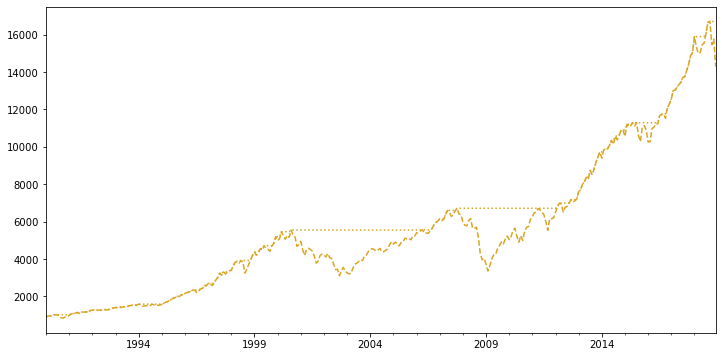

In [37]:
rets_tmi = ark.get_total_market_index_returns()["1990":]
dd_tmi = ark.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6),ls="--",color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax,ls=":",color="goldenrod")

In [38]:
cashrate = 0.03
monthly_cash_return = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cash_return, index = rets_tmi.index,columns = [0])
rets_maxdd25 = ark.bt_mix(pd.DataFrame(rets_tmi),rets_cash,allocator=ark.drawdown_allocator,maxdd=0.25,m=5)
dd_25=ark.drawdown(rets_maxdd25[0])

<AxesSubplot:>

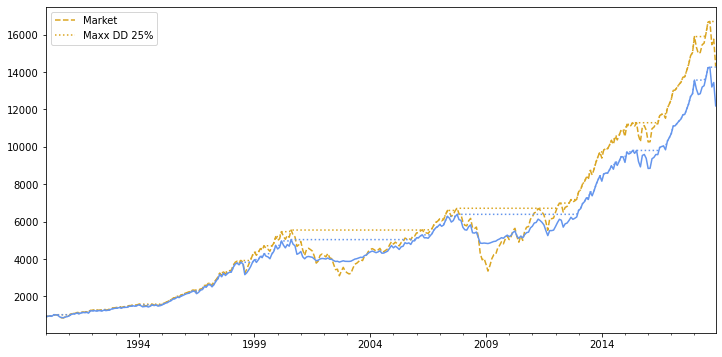

In [41]:
ax = dd_tmi["Wealth"].plot(figsize=(12,6),ls="--",color="goldenrod",label="Market",legend=True)
dd_tmi["Previous Peak"].plot(ax=ax,ls=":",color="goldenrod")
dd_25["Wealth"].plot(ax=ax,label="Maxx DD 25%",color="cornflowerblue",legend=True)
dd_25["Previous Peak"].plot(ax=ax,ls=":",color="cornflowerblue")

In [44]:
ark.summary_stats(pd.concat([rets_tmi.rename("Market"),rets_maxdd25[0].rename("MaxDD")],axis=1))

,Annualized Return,Annualized Volatity,Skewness,Kurtosis,Cornish-Fisher VaR,Historic cVaR,Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.072102,0.652931,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.048441,0.788963,-0.244212
